Alan_Nasibullin_386496588


Алан Насибуллин P32211 openedu(lm2002)

In [2]:
# for TPU
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pickle
import numpy as np
# from albumentations.pytorch import ToTensorV2
# from albumentations import Rotate
from skimage import io
import albumentations as A
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
# import torch_xla
# import torch_xla.core.xla_model as xm

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CUDA is available!  Training on GPU ...


In [4]:
os.getcwd()

'/kaggle/working'

In [5]:
!ls /kaggle/input/journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


In [6]:
os.chdir('../input/journey-springfield')
os.getcwd()

'/kaggle/input/journey-springfield'

In [7]:
os.listdir()

['sample_submission.csv', 'testset', 'characters_illustration.png', 'train']

In [8]:
from pathlib import Path

TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_files[0]

PosixPath('train/simpsons_dataset/charles_montgomery_burns/pic_0503.jpg')

In [12]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 288
# работаем на видеокарте
DEVICE = torch.device("cuda")#xm.xla_device()
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode,transorm_to_image,label_encoder):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transorm_to_image = transorm_to_image

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = label_encoder
        self.labels = [path.parent.name for path in self.files]


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transorm_to_image(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [13]:
train_transform = transforms.Compose([
#             transforms.RandomResizedCrop(244),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
val_transform =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder().fit(os.listdir('train/simpsons_dataset'))

In [15]:
len(set(os.listdir('train/simpsons_dataset')))

42

In [16]:
val_dataset = SimpsonsDataset(val_files,'val',val_transform,label_encoder)
train_dataset = SimpsonsDataset(train_files,'train',train_transform,label_encoder)


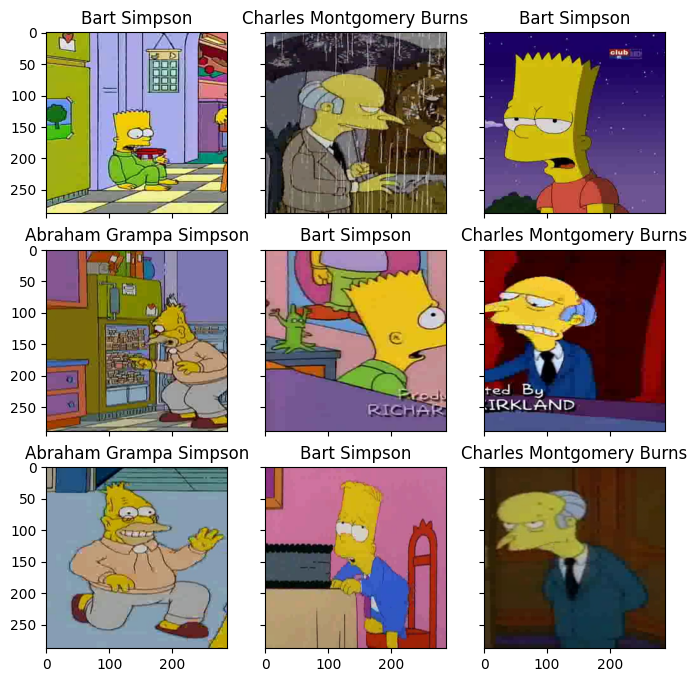

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [18]:
torch.cuda.empty_cache()

In [19]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))

# model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1, progress=True) 

# for param in model.parameters():
#     param.requires_grad = True

# # for param in model.features[:-layers_to_unfreeze].parameters():
# #     param.requires_grad = False

# model.classifier = nn.Sequential(
#     nn.Linear(1280, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(),
#     nn.Linear(256, n_classes)
# )

# model.to(DEVICE)
# model.classifier

efficientnet_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1, progress=True)

for param in efficientnet_b2.parameters():
    param.requires_grad = True

efficientnet_b2.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
)

efficientnet_b2.to(DEVICE)
model = efficientnet_b2


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 118MB/s] 


In [20]:
# !pip install torchsummary

In [21]:
# summary(model, (3, 384, 384))

In [22]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [24]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [26]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.4907781239284574


epoch:  10%|█         | 1/10 [05:59<53:56, 359.61s/it]


Epoch 001 train_loss: 0.4908     val_loss 0.2248 train_acc 0.8890 val_acc 0.9444
loss 0.4863619957840543


epoch:  20%|██        | 2/10 [10:37<41:33, 311.63s/it]


Epoch 002 train_loss: 0.4864     val_loss 0.2319 train_acc 0.8785 val_acc 0.9452
loss 0.14507197527934718


epoch:  30%|███       | 3/10 [15:21<34:51, 298.73s/it]


Epoch 003 train_loss: 0.1451     val_loss 0.2527 train_acc 0.9622 val_acc 0.9352
loss 0.10082122383394684


epoch:  40%|████      | 4/10 [20:09<29:27, 294.66s/it]


Epoch 004 train_loss: 0.1008     val_loss 0.2072 train_acc 0.9743 val_acc 0.9522
loss 0.1192371795441939


epoch:  50%|█████     | 5/10 [24:53<24:15, 291.00s/it]


Epoch 005 train_loss: 0.1192     val_loss 0.2848 train_acc 0.9697 val_acc 0.9345
loss 0.10609475517680717


epoch:  60%|██████    | 6/10 [29:36<19:12, 288.13s/it]


Epoch 006 train_loss: 0.1061     val_loss 0.2281 train_acc 0.9713 val_acc 0.9505
loss 0.09102968120745424


epoch:  70%|███████   | 7/10 [34:16<14:16, 285.43s/it]


Epoch 007 train_loss: 0.0910     val_loss 0.1817 train_acc 0.9768 val_acc 0.9599
loss 0.0879514856582326


epoch:  80%|████████  | 8/10 [38:58<09:28, 284.38s/it]


Epoch 008 train_loss: 0.0880     val_loss 0.2027 train_acc 0.9787 val_acc 0.9520
loss 0.0877754659937065


epoch:  90%|█████████ | 9/10 [43:47<04:45, 285.84s/it]


Epoch 009 train_loss: 0.0878     val_loss 0.1922 train_acc 0.9769 val_acc 0.9603
loss 0.09806533770378141


epoch: 100%|██████████| 10/10 [48:31<00:00, 291.14s/it]


Epoch 010 train_loss: 0.0981     val_loss 0.1839 train_acc 0.9752 val_acc 0.9574


In [27]:
loss, acc, val_loss, val_acc = zip(*history)

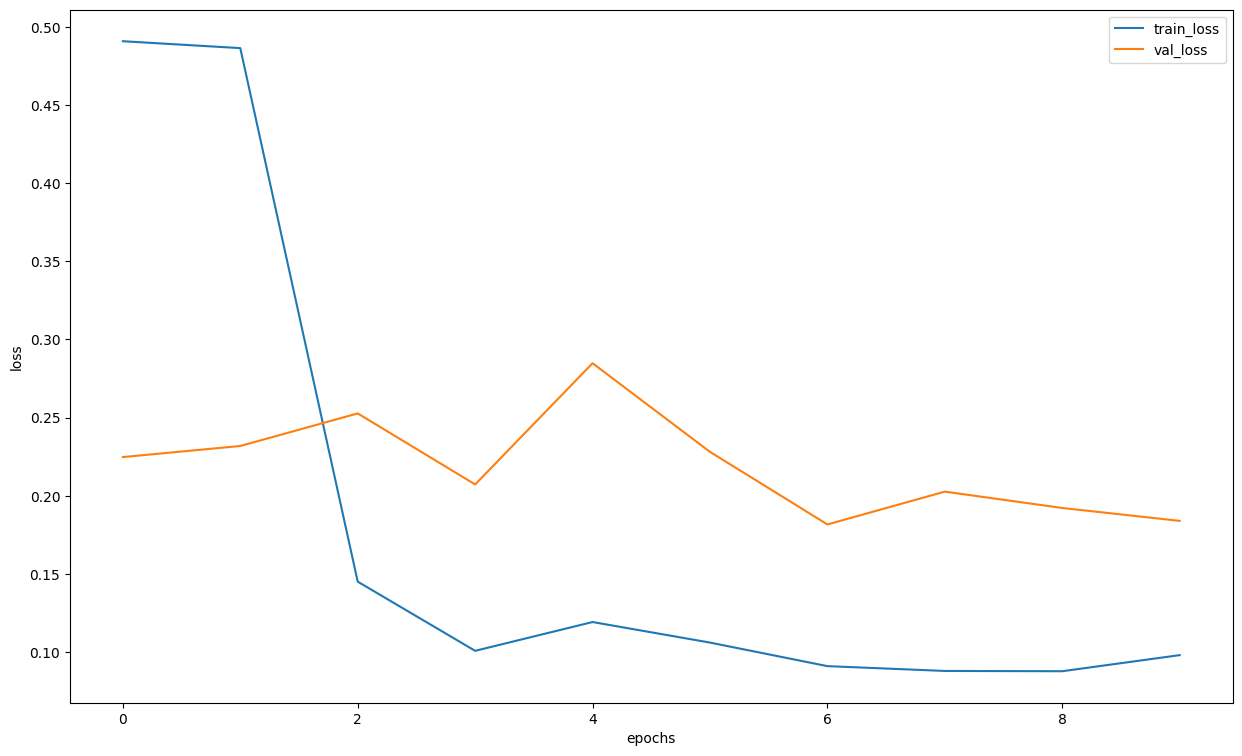

In [28]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [36]:
np.array(list(map(lambda x: x.cpu().numpy(),val_acc))).shape

(10,)

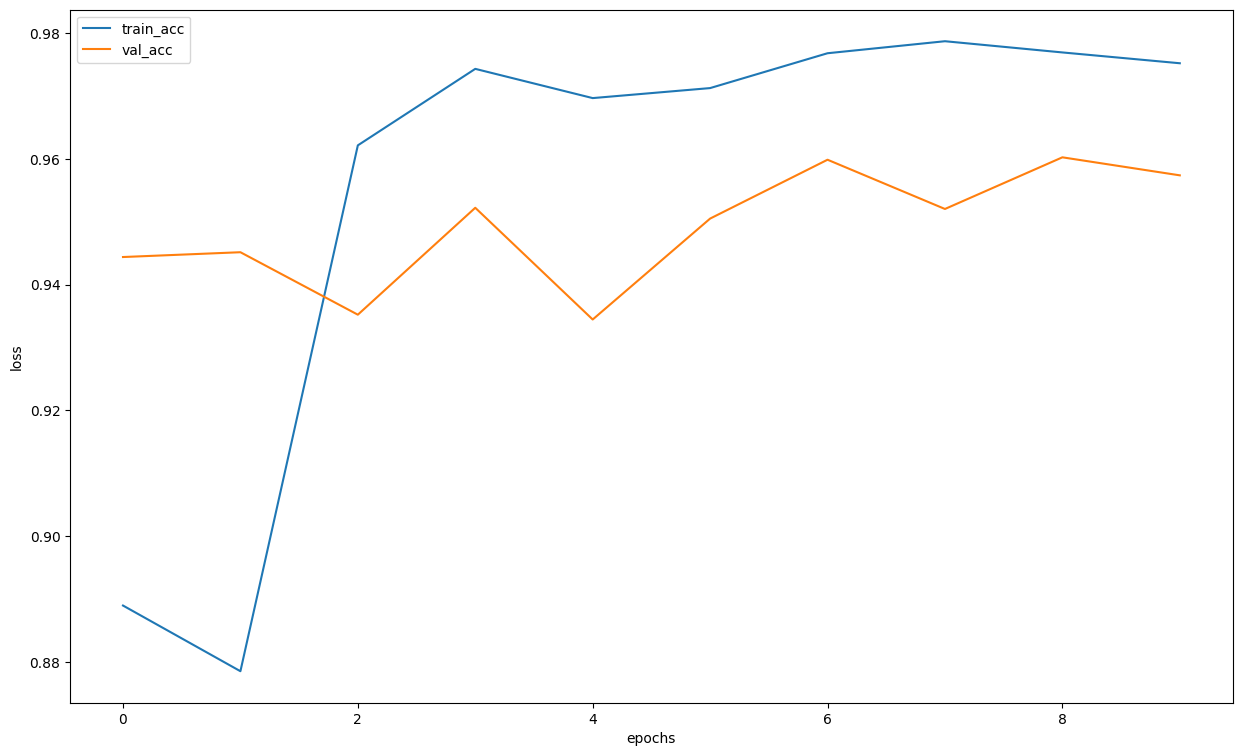

In [37]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(np.array(list(map(lambda x: x.cpu().numpy(),val_acc))), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [29]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [38]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [40]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [41]:
label_encoder = label_encoder

In [42]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [43]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9500000000000001


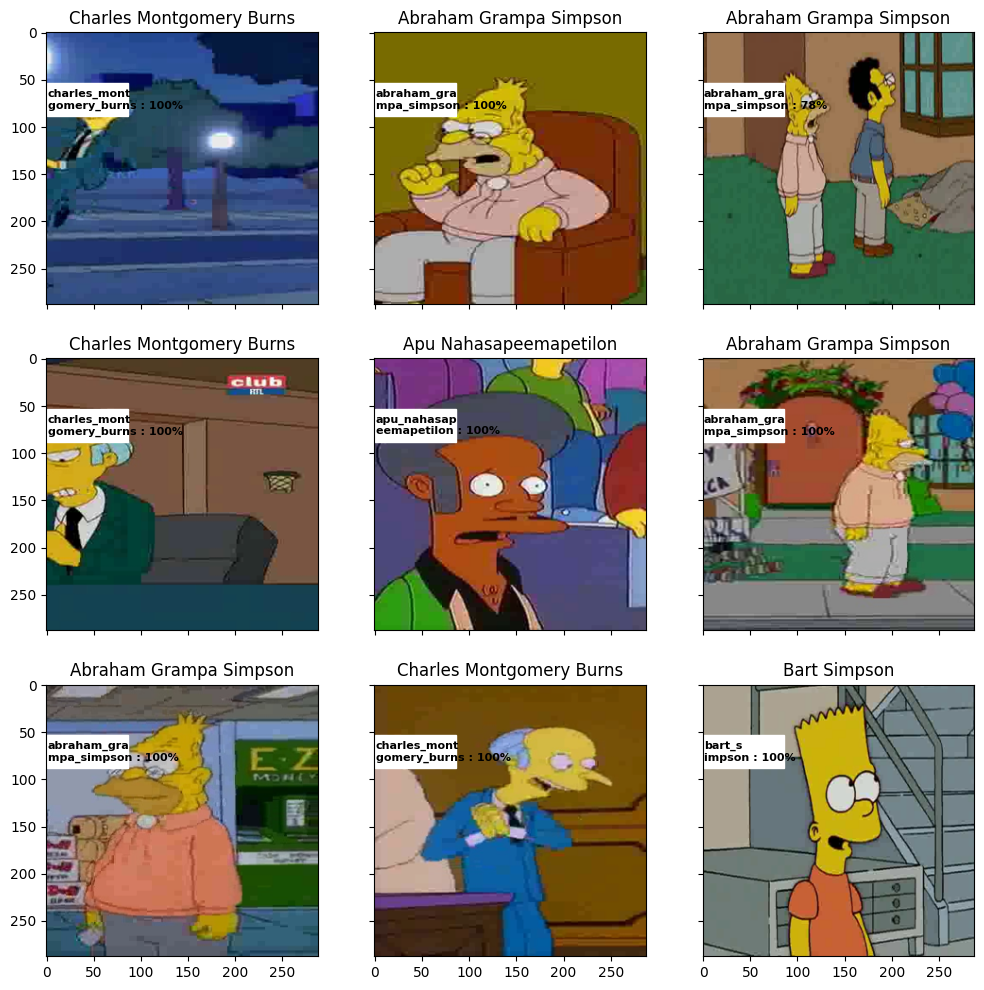

In [45]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [48]:
test_dataset = SimpsonsDataset(test_files, "test",val_transform,label_encoder)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [63]:
import pandas as pd
# my_submit = pd.read_csv("./sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [64]:
os.getcwd()

'/kaggle/input/journey-springfield'

In [65]:
!ls ../../working

submission.csv


In [66]:
os.chdir('../../working')

In [67]:
# os.chdir('../input/journey-springfield')

In [68]:
!ls

submission.csv


In [69]:
my_submit.to_csv('submission.csv', index=False)
from IPython.display import FileLink
FileLink('submission.csv') # file

/kaggle/working/submission.csv

In [62]:
pd.read_csv('sample_submission.csv')

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson
...,...,...
986,img986.jpg,bart_simpson
987,img987.jpg,bart_simpson
988,img988.jpg,bart_simpson
989,img989.jpg,bart_simpson
